In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [15]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
from sklearn import decomposition
from Behavior.behavior import get_extent, get_idxs_behav_state, get_idxs_in_patches
from Behavior.behavior import density_map, density_map, get_idxs_neuro_state
from matplotlib.lines import Line2D
from population import unit_response_matrix, pop_activity_phase_shifted
from matplotlib.lines import Line2D
import itertools

In [16]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [86]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

# 009266
sessions = [s for s in selected_009266.keys()]
sessions.sort()
selected = sessions[:]
# selected.remove('009266_hippoSIT_2023-04-21_08-43-00')
# selected.remove('009266_hippoSIT_2023-06-14_08-21-23')
# selected.remove('009266_hippoSIT_2023-06-19_08-58-35')


# 009265
sessions = [s for s in selected_009265.keys()]
sessions.sort()
sessions.remove('009265_hippoSIT_2023-02-27_10-18-32')
sessions.remove('009265_hippoSIT_2023-02-27_15-33-46')
sessions = sessions[9:-2]
selected = selected + sessions

# animal 57
# selected = [
#     "57_SIT_2023-12-22_14-08-07",
#     "57_SIT_2023-12-22_17-37-18",
#     "57_SIT_2023-12-28_16-43-28",
#     "57_SIT_2023-12-29_11-06-26",
#     "57_SIT_2023-12-29_11-40-14",
#     "57_SIT_2024-01-02_16-38-05",
#     "57_SIT_2024-01-02_17-10-09",
#     "57_SIT_2024-01-03_19-54-59",
# ]

# selected = [
#     '009265_hippoSIT_2023-03-09_20-03-08',
#     '009265_hippoSIT_2023-03-05_11-52-17'
# ]
selected

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34']

In [87]:
# select binning for target / backgound
binning_mPFC_AEP = {
    50:  [8, 25, 45, 85, 105],
    75:  [8, 25, 45, 105, 127],
    100: [8, 25, 45, 128, 155],
}

binning_mPFC_PCA = {
    50:  [8, 16, 65, 85],
    75:  [8, 16, 90, 110],
    100: [8, 16, 115, 135],
}

binning_AC_AEP = {
    50:  [15, 28, 73, 100],
    90:  [15, 28, 107, 135],
    100: [15, 28, 118, 145],
    150: [15, 28, 168, 195],
}

# for the moment define binning scheme manually for each animal
all_binnings = {
    '009265': binning_AC_AEP,
    '009266': binning_AC_AEP,
    '57': binning_mPFC_PCA,
}

nMAP_electrodes = {
    '009265': [1, 2],
    '009266': [1, 2],
    '57': [1]
}

In [113]:
def z_score_mx(mx, k_width=None):
    if k_width is not None:
        kernel  = signal.gaussian(k_width, std=(k_width) / 7.2)
    
    unit_act_matrix = mx.T
    for u, unit_data in enumerate(unit_act_matrix):
        unit_act_matrix[u] = stats.zscore(unit_data)
        #unit_act_matrix[u] = unit_data - unit_data.mean()
        if k_width is not None:
            unit_act_matrix[u] = np.convolve(unit_act_matrix[u], kernel, 'same') / kernel.sum()
    return unit_act_matrix.T

In [89]:
def get_asterisks(pval):
    if pval > 0.05:
        return 'n.s.'
    elif pval > 0.01:
        return '*'
    elif pval > 0.001:
        return '**'
    else:
        return '***'

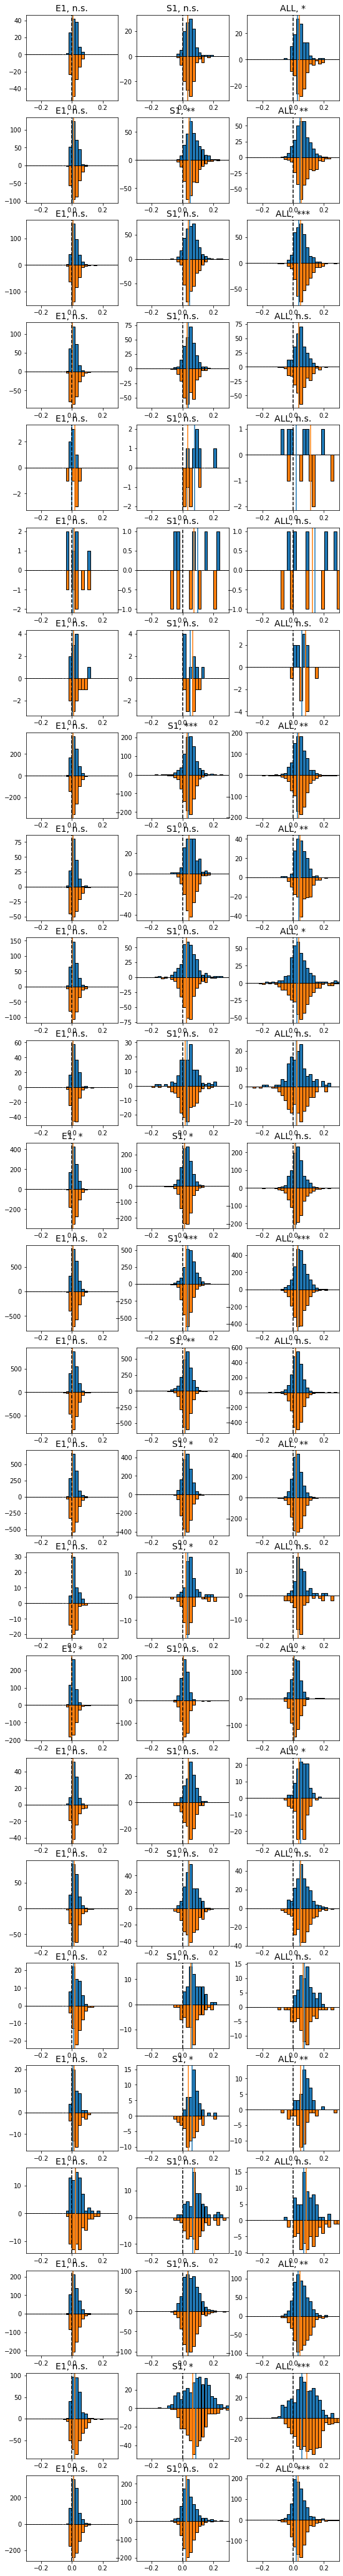

In [116]:
ft, fp = 'tSNE', 70
rows = len(selected)
cols = 3
size = 3
fig, axes = plt.subplots(rows, cols, figsize=(cols*size, rows*size))
titles = ['E1', 'S1', 'ALL']

all_corrs = {'E1_A': [], 'E1_B': [], 'S1_A': [], 'S1_B': [], 'ALL_A': [], 'ALL_B': []}

for i, session in enumerate(selected):
    animal = session.split('_')[0]

    s_path     = os.path.join(source, animal, session)
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    umap_file  = os.path.join(source, animal, session, 'analysis', 'W1-W4_tSNE_UMAP.h5')
    nMAP_seg_file = os.path.join(source, animal, session, 'analysis', 'nMAP_segmentation.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
        cfg = json.loads(f['processed'].attrs['parameters'])
    with h5py.File(umap_file, 'r') as f:
        n_fit = np.array(f[ft][str(fp)])
        extent = get_extent(n_fit, margin=5)
    with h5py.File(nMAP_seg_file, 'r') as f:
        idxs_tgt_succ_state_ev = np.array(f['idxs_tgt_succ_state_ev'])

    # states
    idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(events[:, 1] == 2)[0]
    idxs_noi_ev = np.where(events[:, 1] == -1)[0]
    idxs_bgr_AL = np.intersect1d(idxs_bgr_ev, idxs_tgt_succ_state_ev)
    idxs_bgr_PH = np.array([x for x in idxs_bgr_ev if not x in idxs_tgt_succ_state_ev])
    
    # define actual binning for target / background
    dur_bgr = int(cfg['sound']['sounds']['background']['duration'] * 1000)  # in ms
    dur_tgt = int(cfg['sound']['sounds']['target']['duration'] * 1000)  # in ms
    
    selected_binning = all_binnings[animal] if animal in all_binnings else binning_AC_AEP
    
    bins_bgr = selected_binning[dur_bgr]
    bins_tgt = selected_binning[dur_tgt]
    bins_all = [10]
    assert dur_bgr in selected_binning
    assert dur_tgt in selected_binning

    # electrodes in A1, unit mx z-scored
    k_width = None
    electrodes = nMAP_electrodes[animal]
    unit_mx_bgr = z_score_mx(unit_response_matrix(s_path, electrodes, bins_bgr)[1], k_width)
    unit_mx_tgt = z_score_mx(unit_response_matrix(s_path, electrodes, bins_tgt)[1], k_width)
    unit_mx_all = z_score_mx(unit_response_matrix(s_path, electrodes, bins_all)[1], k_width)
        
    # compute correlations
    unit_pair_idxs = [x for x in itertools.combinations(range(unit_mx_bgr.shape[1]), 2)]
    idxs_A = idxs_bgr_ev # idxs_bgr_AL
    idxs_B = idxs_sil_ev # idxs_bgr_PH
    corrs = np.zeros([len(unit_pair_idxs), 6])  # E1 BGR, E1 TGT, S1 BGR, S1 TGT, ALL BGR, ALL TGT
    pvals = np.zeros([len(unit_pair_idxs), 6])  # E1 BGR, E1 TGT, S1 BGR, S1 TGT, ALL BGR, ALL TGT
    for j, pair in enumerate(unit_pair_idxs):
        # E1 BGR
        u1 = unit_mx_bgr[::len(bins_bgr)+1][idxs_A][:, pair[0]]
        u2 = unit_mx_bgr[::len(bins_bgr)+1][idxs_A][:, pair[1]]
        corr, pval = stats.pearsonr(u1, u2)
        corrs[j][0] = corr
        pvals[j][0] = pval
        
        # E1 TGT
        u1 = unit_mx_tgt[::len(bins_tgt)+1][idxs_B][:, pair[0]]
        u2 = unit_mx_tgt[::len(bins_tgt)+1][idxs_B][:, pair[1]]
        corr, pval = stats.pearsonr(u1, u2)
        corrs[j][1] = corr
        pvals[j][1] = pval
        
        # S1 BGR
        u1 = unit_mx_bgr[4::len(bins_bgr)+1][idxs_A][:, pair[0]]
        u2 = unit_mx_bgr[4::len(bins_bgr)+1][idxs_A][:, pair[1]]
        corr, pval = stats.pearsonr(u1, u2)
        corrs[j][2] = corr
        pvals[j][2] = pval
        
        # S1 TGT
        u1 = unit_mx_tgt[4::len(bins_tgt)+1][idxs_B][:, pair[0]]
        u2 = unit_mx_tgt[4::len(bins_tgt)+1][idxs_B][:, pair[1]]
        corr, pval = stats.pearsonr(u1, u2)
        corrs[j][3] = corr
        pvals[j][3] = pval

        # ALL BGR
        u1 = unit_mx_all[1::len(bins_all)+1][idxs_A][:, pair[0]]
        u2 = unit_mx_all[1::len(bins_all)+1][idxs_A][:, pair[1]]
        corr, pval = stats.pearsonr(u1, u2)
        corrs[j][4] = corr
        pvals[j][4] = pval
        
        # ALL BGR
        u1 = unit_mx_all[1::len(bins_all)+1][idxs_B][:, pair[0]]
        u2 = unit_mx_all[1::len(bins_all)+1][idxs_B][:, pair[1]]
        corr, pval = stats.pearsonr(u1, u2)
        corrs[j][5] = corr
        pvals[j][5] = pval
    
    for j, m_name in enumerate(['E1_A', 'E1_B', 'S1_A', 'S1_B', 'ALL_A', 'ALL_B']):
        all_corrs[m_name] = all_corrs[m_name] + list(corrs[:, j])
        
    bins = np.linspace(-1, 1, 100)
    for j, ax in enumerate(axes[i]):
        h1, _ = np.histogram(corrs[:, 2*j], bins=bins)
        h2, _ = np.histogram(corrs[:, 2*j+1], bins=bins)
        
        _, pval = stats.mannwhitneyu(corrs[:, 2*j], corrs[:, 2*j+1])
        
        ax.bar(bins[1:], h1, width=2/100, edgecolor='black')
        ax.bar(bins[1:], -h2, width=2/100, edgecolor='black')
        #ax.bar(corrs[:, 2*j+1], bins=bins, edgecolor='black', alpha=0.7, color='tab:orange')
        #ax.bar(corrs[:, 2*j + count],   bins=bins, edgecolor='black', alpha=0.7, color='tab:blue')

        ax.axvline(np.median(corrs[:, 2*j]), color='tab:blue')
        ax.axvline(np.median(corrs[:, 2*j+1]), color='tab:orange')
        ax.axvline(0, color='black', ls='--')
        ax.set_xlim(-0.3, 0.3)
        ax.set_title(titles[j] + ', ' + get_asterisks(pval), fontsize=14)


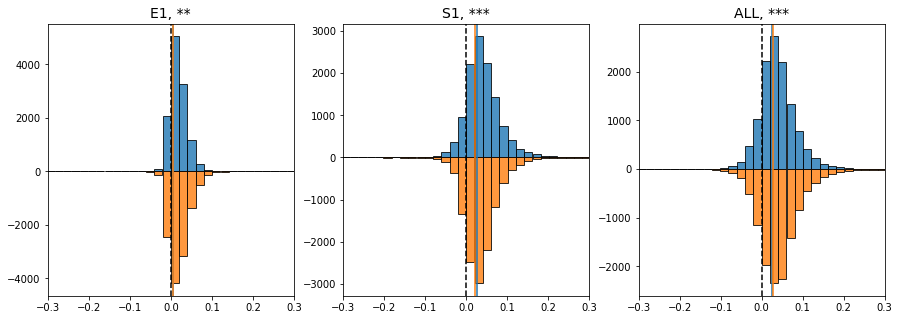

In [117]:
# cross-session
fig, axes = plt.subplots(1, cols, figsize=(cols*5, 5))

m_names = ['E1_A', 'E1_B', 'S1_A', 'S1_B', 'ALL_A', 'ALL_B']
bins = np.linspace(-1, 1, 100)
for j, ax in enumerate(axes):
    data_A = all_corrs[m_names[2*j]]
    data_B = all_corrs[m_names[2*j+1]]
    
    hA, _ = np.histogram(data_A, bins=bins)
    hB, _ = np.histogram(data_B, bins=bins)

    _, pval = stats.mannwhitneyu(data_A, data_B)

    ax.bar(bins[1:], hA, width=2/100, edgecolor='black', alpha=0.8)
    ax.bar(bins[1:], -hB, width=2/100, edgecolor='black', alpha=0.8)

    ax.axvline(np.median(data_A), color='tab:blue')
    ax.axvline(np.median(data_B), color='tab:orange')
    ax.axvline(0, color='black', ls='--')
    ax.set_xlim(-0.3, 0.3)
    ax.set_title(titles[j] + ', ' + get_asterisks(pval), fontsize=14)